# Exploring the Efficacy of Supervised and Self-Supervised Learning for Wildlife Image Classification: A Case Study in Tiputini, Ecuador

**Author:** Diego Villacreses

**Last Updated:** December 1, 2024

In [34]:
import os
import sys
current_dir = "/home/dvillacreses/code"
src_dir = os.path.join(current_dir, "src")
sys.path.append(src_dir)
os.chdir(current_dir)


from src.config import dir_data_labeled, TARGET_SIZE, MAX_EPOCHS_SUPERVISED, PATH_OUTPUTS, NUM_WORKERS_SUPERVISED, NUM_WORKERS_SIMCLR, PATH_OUTPUT_GRAPHS, PATH_OUTPUT_TABLES
from src.utils import seed_everything
from src.data_processing import load_labeled_data, df_undersampling_strat, load_unlabeled_metadata, train_transform_labeled, val_transform_labeled,train_transform_labeled_vit, val_transform_labeled_vit, contrast_transforms, val_transform_labeled_simclr, ContrastiveTransformations
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from src.datasets import UnlabelDataModule, LabeledDataModule, LabeledImageDataset
from src.models import CNNLightningModule, ViTLightningModule, EmbeddingExtractor_VIT, prepare_data_features, train_logreg, get_smaller_dataset
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import random
import torch
from src.training import train_supervised_model, train_supervised_model_v2, train_simclr

from itertools import product
import time
import pickle
from tqdm import tqdm
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

# Global variables
TRAIN_GRID_SUPERVISED = False
TRAIN_ENCODER_SIMCLR = False
TRAIN_GRID_SIMCLR_CLASSIFIER = False
COMPUTE_STATISTICAL_COMPARISON = False

## Data Loading

### Labeled Data

In [2]:
# Load and prepare data
df = load_labeled_data(dir_data_labeled)
# df.shape=(7337, 6)

df['u']=1
df_balanced = pd.concat([
    df_undersampling_strat(df[df['subset']=='train'],subset_col='u',label_col='label'),
    df_undersampling_strat(df[df['subset']=='valid'],subset_col='u',label_col='label'),
    df_undersampling_strat(df[df['subset']=='test'],subset_col='u',label_col='label')
])

df.shape=(7337, 6)


### Unlabeled Data

In [3]:
unlabeled_metadata = load_unlabeled_metadata()
files_list = unlabeled_metadata[0]
bbox_list = unlabeled_metadata[1]
num_files = len(files_list)

# Set a test size (e.g., 20% for testing)
test_size = 0.2
indices = np.arange(num_files)

# Shuffle the indices to ensure random distribution
np.random.seed(0)  # For reproducibility
np.random.shuffle(indices)

# Calculate the split point
split_idx = int(num_files * (1 - test_size))

# Split indices for training and testing
train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

## Supervised Grid Search

In [4]:
# Grid Search Supervised Learning
df_grid = pd.DataFrame(product([0.001,0.0001],[32,64],[0,0.15, 0.5, 0.8, 0.95],['resnet','vgg','efficientnet', 'vit']),
                       columns = ['lr', 'batch_size','frozen_prop','model_name'])

if TRAIN_GRID_SUPERVISED:
    all_results_list = []
    ## Loop for grid_search
    for i in range(df_grid.shape[0]):
        lr, batch_size, frozen_prop, model_name = df_grid.iloc[i,:]
        batch_size = int(batch_size)
        print("-"*50)
        print(f'Iter: {i+1}/{df_grid.shape[0]} - lr: {lr}, batch_size: {batch_size}, frozen_prop: {frozen_prop}, model_name: {model_name}')
        print("-"*50)
        # Seed for reproducibility
        seed_everything(0)
        # Start datasets
        if model_name != 'vit':
            train_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
                transform=train_transform_labeled
                )
            valid_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
                transform=val_transform_labeled
                )
            test_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
                transform=val_transform_labeled
                )
        if model_name == 'vit':
            train_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
                transform=train_transform_labeled_vit
                )
            valid_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
                transform=val_transform_labeled_vit
                )
            test_dataset_labeled = LabeledImageDataset(
                image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
                labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
                transform=val_transform_labeled_vit
                )

        # Start lightning data module
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=batch_size,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        # Start model instance
        if model_name != 'vit':
            lightning_model = CNNLightningModule(learning_rate=lr,
                                                frozen_prop=frozen_prop,
                                                model_name=model_name)
        if model_name == 'vit':
            lightning_model = ViTLightningModule(learning_rate=lr,
                                                frozen_prop=frozen_prop)
        # Train model
        results_list = train_supervised_model(lightning_model,
                                            labeled_datamodule, 
                                            total_epochs=MAX_EPOCHS_SUPERVISED,
                                            model_name=model_name)
        # Save results in a list
        all_results_list.append(results_list)
        
        # Locally save after each iteration
        with open(os.path.join(PATH_OUTPUTS,'all_results_grid_supervised.pkl'), 'wb') as file:
            pickle.dump(all_results_list, file)

    all_results_list = [all_results_list, df_grid]
    with open(os.path.join(PATH_OUTPUTS,'all_results_grid_supervised.pkl'), 'wb') as file:
        pickle.dump(all_results_list, file)
if not TRAIN_GRID_SUPERVISED:
    with open(os.path.join(PATH_OUTPUTS,'all_results_grid_supervised.pkl'), 'rb') as file:
        all_results_list = pickle.load(file)

## SimCLR

In [5]:
if TRAIN_ENCODER_SIMCLR:
    # Code taken (with minimum modifications for dataloading): https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/13-contrastive-learning.html
    # Unlabel Data Module
    #batch_size = 2**8 # 512
    batch_size = 2**7
    train_loader = UnlabelDataModule(image_list_dir = [files_list[i] for i in train_indices],
                                crop_list=[bbox_list[i] for i in train_indices],
                                batch_size=batch_size,
                                num_workers=NUM_WORKERS_SIMCLR,
                                        transform = ContrastiveTransformations(contrast_transforms, n_views=2))
    train_loader.setup()
    train_loader = train_loader.train_dataloader()

    val_loader = UnlabelDataModule(image_list_dir = [files_list[i] for i in test_indices],
                                crop_list=[bbox_list[i] for i in test_indices],
                                batch_size=batch_size,
                                num_workers=NUM_WORKERS_SIMCLR,
                                        transform = ContrastiveTransformations(contrast_transforms, n_views=2))
    val_loader.setup()
    val_loader = val_loader.valid_dataloader()
    
    # Training
    t0 = time.time()
    simclr_model = train_simclr(batch_size=batch_size,
                                hidden_dim=128,
                                lr=1e-4,
                                temperature=0.07,
                                weight_decay=1e-4,
                                max_epochs=500,
                                train_loader=train_loader,
                                val_loader=val_loader)
    t1 = time.time()
    # 972.7 minutes
    train_time = np.round((t1-t0)/60,1)
    print(f"Training time in minutes for SimCLR with ResNet: {train_time}")
    with open(os.path.join(PATH_OUTPUTS, 'resnet50_simclr_model.pkl'), "wb") as file:
        pickle.dump(simclr_model, file)
if not TRAIN_ENCODER_SIMCLR:
    with open(os.path.join(PATH_OUTPUTS, 'resnet50_simclr_model.pkl'), "rb") as file:
        simclr_model = pickle.load(file)

In [6]:
if TRAIN_GRID_SIMCLR_CLASSIFIER:
    t0 = time.time()
    num_imgs_per_label = 100_000
    df_grid_simclr = pd.DataFrame(product([16,32, 64],[1e-5, 1e-4, 1e-3],[0,1e-3,0.01,0.1]),
                                columns = ['batch_size','lr','weight_decay'])
    df_grid_simclr['valid_acc'] = 0

    train_dataset_labeled = LabeledImageDataset(
        image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
        labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
        transform=val_transform_labeled_simclr
        )
    valid_dataset_labeled = LabeledImageDataset(
        image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
        labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
        transform=val_transform_labeled_simclr
        )
    test_dataset_labeled = LabeledImageDataset(
        image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
        labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
        transform=val_transform_labeled_simclr
        )

    res_list = []
    for i in range(df_grid_simclr.shape[0]):
        batch_size,lr,weight_decay, _ = df_grid_simclr.iloc[i, :]
        batch_size = int(batch_size)

        # Start lightning data module
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=batch_size,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        train_loader_classifier = labeled_datamodule.train_dataloader()
        valid_loader_classifier = labeled_datamodule.val_dataloader()

        train_feats_simclr = prepare_data_features(simclr_model, train_loader_classifier)
        test_feats_simclr = prepare_data_features(simclr_model, valid_loader_classifier)

        sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
        _, small_set_results = train_logreg(batch_size=batch_size,
                                            train_feats_data=sub_train_set,
                                            test_feats_data=test_feats_simclr,
                                            model_suffix=num_imgs_per_label,
                                            feature_dim=train_feats_simclr.tensors[0].shape[1],
                                            num_classes=2,
                                            lr=lr,
                                            weight_decay=weight_decay)
        print("-"*100)
        print(i, batch_size,lr,weight_decay, small_set_results['test'])
        df_grid_simclr.loc[i, 'valid_acc'] = small_set_results['test']
        # 288 minutes
    t1 = time.time()
    print(f"Total training time in minutes: {np.round((t1-t0/60),2)}")
    df_grid_simclr.to_pickle(os.path.join(PATH_OUTPUTS, 'simclr_classifier_grid.pkl'))
if not TRAIN_GRID_SIMCLR_CLASSIFIER:
    df_grid_simclr = pd.read_pickle(os.path.join(PATH_OUTPUTS, 'simclr_classifier_grid.pkl'))

In [7]:
df_grid_simclr.sort_values("valid_acc")

,batch_size,lr,weight_decay,valid_acc
25,64,0.00001,0.001,0.780488
26,64,0.00001,0.010,0.781504
27,64,0.00001,0.100,0.781504
24,64,0.00001,0.000,0.781504
15,32,0.00001,0.100,0.797764
13,32,0.00001,0.001,0.798781
14,32,0.00001,0.010,0.798781
12,32,0.00001,0.000,0.798781
0,16,0.00001,0.000,0.813008
1,16,0.00001,0.001,0.813008


## Statistical Comparison of two best models

In [ ]:
if COMPUTE_STATISTICAL_COMPARISON:
    all_file_names = df.loc[df['subset'].isin(['train', 'valid']), 'file_name'].values

    # Parameters for Repeated K-Fold
    n_splits = 5  # Number of splits for K-Fold
    n_repeats = 3  # Number of repetitions
    random_state = 0  # For reproducibility

    # Initialize Repeated K-Fold
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    l_val_acc_vit = []
    l_val_acc_efficientnet = []
    l_val_acc_simclr = []
    # Loop through each fold
    for repeat_idx, (train_index, valid_index) in enumerate(rkf.split(all_file_names)):
        train_files = all_file_names[train_index]
        valid_files = all_file_names[valid_index]

        df_train = df[df['file_name'].isin(train_files)]
        df_valid = df[df['file_name'].isin(valid_files)]

        df_train['u']=1
        df_valid['u']=1
        df_train['subset'] = 'train'
        df_train['subset'] = 'valid'
        df_balanced_rfk = pd.concat([
            df_undersampling_strat(df_train,subset_col='u',label_col='label'),
            df_undersampling_strat(df_valid,subset_col='u',label_col='label'),
            df_undersampling_strat(df[df['subset']=='test'],subset_col='u',label_col='label')
        ])

        # EfficienNet
        train_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='train','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='train','label'].to_list(),
            transform=train_transform_labeled
            )
        valid_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='valid','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='valid','label'].to_list(),
            transform=val_transform_labeled
            )
        test_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='test','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='test','label'].to_list(),
            transform=val_transform_labeled
            )
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=32,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        lightning_model = CNNLightningModule(learning_rate=0.0001,
                                                frozen_prop=0.15,
                                                model_name='efficientnet')
        results_list_1 = train_supervised_model(lightning_model,
                                            labeled_datamodule, 
                                            total_epochs=MAX_EPOCHS_SUPERVISED,
                                            model_name='efficientnet')

        # ViT
        train_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='train','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='train','label'].to_list(),
            transform=train_transform_labeled_vit
            )
        valid_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='valid','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='valid','label'].to_list(),
            transform=val_transform_labeled_vit
            )
        test_dataset_labeled = LabeledImageDataset(
            image_list = df_balanced_rfk.loc[df_balanced_rfk['subset']=='test','cropped_image'].to_list(),
            labels=df_balanced_rfk.loc[df_balanced_rfk['subset']=='test','label'].to_list(),
            transform=val_transform_labeled_vit
            )
        lightning_model = ViTLightningModule(learning_rate=0.0001,
                                            frozen_prop=0)
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=64,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        results_list_2 = train_supervised_model(lightning_model,
                                            labeled_datamodule, 
                                            total_epochs=MAX_EPOCHS_SUPERVISED,
                                            model_name='vit')
        
        # SimCLR
        # Start lightning data module
        labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                            valid_dataset_labeled, 
                                            test_dataset_labeled, 
                                            batch_size=32,
                                            num_workers=NUM_WORKERS_SUPERVISED)
        train_loader_classifier = labeled_datamodule.train_dataloader()
        valid_loader_classifier = labeled_datamodule.val_dataloader()

        train_feats_simclr = prepare_data_features(simclr_model, train_loader_classifier)
        test_feats_simclr = prepare_data_features(simclr_model, valid_loader_classifier)

        sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
        _, small_set_results = train_logreg(batch_size=32,
                                            train_feats_data=sub_train_set,
                                            test_feats_data=test_feats_simclr,
                                            model_suffix=num_imgs_per_label,
                                            feature_dim=train_feats_simclr.tensors[0].shape[1],
                                            num_classes=2,
                                            lr=0.001,
                                            weight_decay=0.01)


        val_acc_vit = results_list_1[0][0]['val_acc']

        val_acc_efficientnet = results_list_2[0][0]['val_acc']

        val_acc_simclr = small_set_results['test']

    t_stat, t_pval = ttest_ind(l_val_acc_vit, l_val_acc_simclr)
    print(f"T-test ViT vs. SimCLR: t-statistic = {t_stat}, p-value = {t_pval}")
    t_stat, t_pval = ttest_ind(l_val_acc_vit, l_val_acc_efficientnet)
    print(f"T-test ViT vs. EfficientNet: t-statistic = {t_stat}, p-value = {t_pval}")

## Test Accuracy of best model

In [43]:
vit_model = ViTLightningModule.load_from_checkpoint(all_results_list[0][63][2])
vit_model.to(torch.device("cuda"))
vit_model.eval()

train_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
    transform=train_transform_labeled_vit
    )
valid_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
    transform=val_transform_labeled_vit
    )
test_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
    transform=val_transform_labeled_vit
    )

# Start lightning data module
labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                valid_dataset_labeled, 
                                test_dataset_labeled, 
                                batch_size=64,
                                num_workers=NUM_WORKERS_SUPERVISED)

all_preds = []
all_labels = []

test_loader = labeled_datamodule.test_dataloader()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = vit_model(inputs.to(torch.device("cuda")))  # Forward pass
        preds = (outputs>0)*1
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 89.38%


## EDA

### Supervised Models

In [21]:
for i in range(len(all_results_list[0])):
    df_grid.loc[i, ["val_loss", "val_acc", "val_precision", "val_recall"]] = all_results_list[0][i][0][0].values()
    df_grid.loc[i, "train_time_minutes"] = np.round(all_results_list[0][i][3],2)
print(f"{len(all_results_list[0])=}")

df_grid['val_acc_max'] = df_grid.groupby(['model_name'])['val_acc'].transform('max')

df_grid[lambda x: x['val_acc'] == x['val_acc_max']]

len(all_results_list[0])=80


,lr,batch_size,frozen_prop,model_name,val_loss,val_acc,val_precision,val_recall,train_time_minutes,val_acc_max
40,0.0001,32,0.00,resnet,0.318056,0.864837,0.510163,0.436992,4.12,0.864837
46,0.0001,32,0.15,efficientnet,0.288778,0.880081,0.510282,0.449797,12.33,0.880081
63,0.0001,64,0.00,vit,0.255121,0.901423,0.529933,0.491260,9.63,0.901423
65,0.0001,64,0.15,vgg,0.330452,0.861789,0.525745,0.485163,10.51,0.861789


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


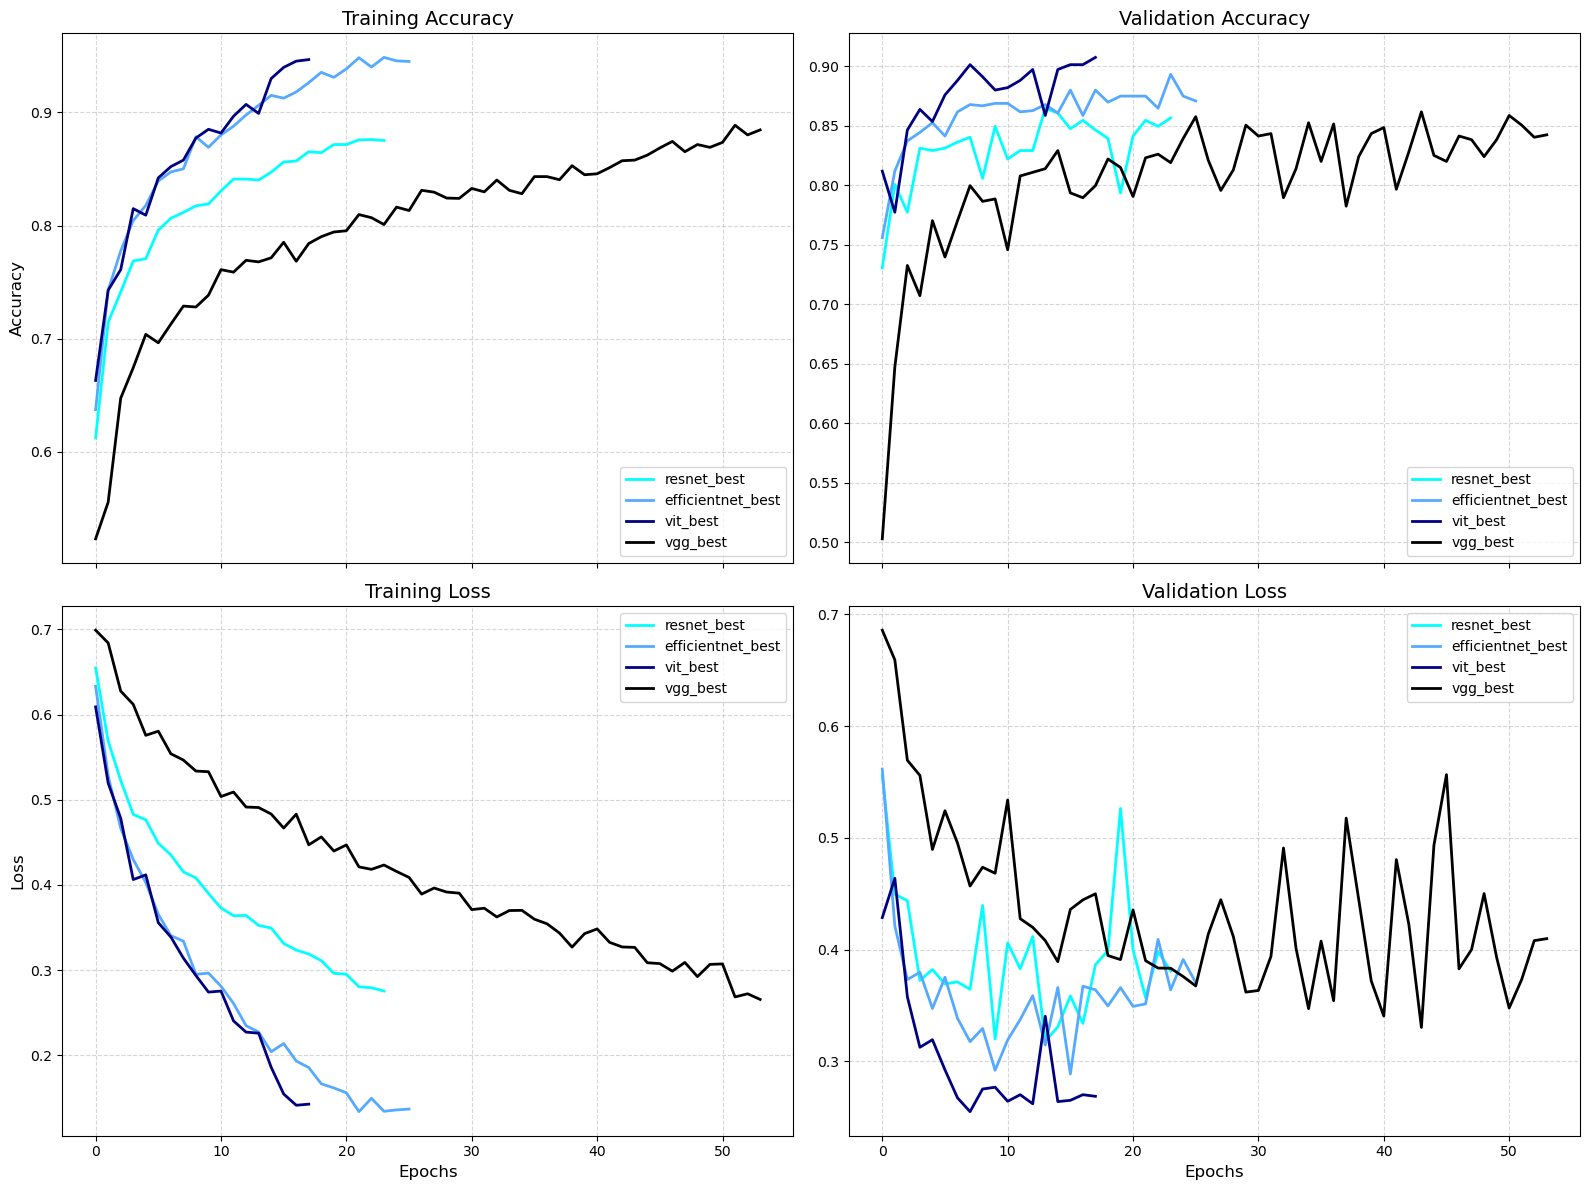

In [22]:
# Compare training and validation loss, accuracy for best hp configuration of each sl model
index_list = df_grid[lambda x: x['val_acc'] == x['val_acc_max']].index
train_acc = {}
val_acc = {}
train_loss = {}
val_loss = {}

for i in index_list:
    res_i = all_results_list[0][i][1].groupby(['epoch']).max().reset_index()[['epoch','train_acc','train_loss','val_acc','val_loss']].dropna()
    res_i.loc[res_i['val_loss']>1,'val_loss'] = np.nan
    name_i = df_grid.loc[i, 'model_name']
    name_i = name_i + '_best'
    train_acc[name_i] = res_i['train_acc'].to_list()
    val_acc[name_i] = res_i['val_acc'].to_list()
    train_loss[name_i] = res_i['train_loss'].to_list()
    val_loss[name_i] = res_i['val_loss'].to_list()

# Define a color map ranging from blue to black
colors = cm.Blues(np.linspace(0.3, 0.8, 4))
colors = cm.ScalarMappable(cmap='cool').to_rgba(np.linspace(0.2, 1.0, 4))
colors[2] = [0., 0., 0.5, 1.] 
colors[3] = [0., 0., 0., 1.] 

# Plot the data with updated colors
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

# Plot training accuracy
for idx, (model, values) in enumerate(train_acc.items()):
    epochs = np.arange(len(values))
    axes[0, 0].plot(epochs, values, label=model, linewidth=2.0, color=colors[idx])
axes[0, 0].set_title("Training Accuracy", fontsize=14)
axes[0, 0].set_ylabel("Accuracy", fontsize=12)
axes[0, 0].grid(alpha=0.5, linestyle='--')
axes[0, 0].legend(fontsize=10)

# Plot validation accuracy
for idx, (model, values) in enumerate(val_acc.items()):
    epochs = np.arange(len(values))
    axes[0, 1].plot(epochs, values, label=model, linewidth=2.0, color=colors[idx])
axes[0, 1].set_title("Validation Accuracy", fontsize=14)
axes[0, 1].grid(alpha=0.5, linestyle='--')
axes[0, 1].legend(fontsize=10)

# Plot training loss
for idx, (model, values) in enumerate(train_loss.items()):
    epochs = np.arange(len(values))
    axes[1, 0].plot(epochs, values, label=model, linewidth=2.0, color=colors[idx])
axes[1, 0].set_title("Training Loss", fontsize=14)
axes[1, 0].set_xlabel("Epochs", fontsize=12)
axes[1, 0].set_ylabel("Loss", fontsize=12)
axes[1, 0].grid(alpha=0.5, linestyle='--')
axes[1, 0].legend(fontsize=10)

# Plot validation loss
for idx, (model, values) in enumerate(val_loss.items()):
    epochs = np.arange(len(values))
    axes[1, 1].plot(epochs, values, label=model, linewidth=2.0, color=colors[idx])
axes[1, 1].set_title("Validation Loss", fontsize=14)
axes[1, 1].set_xlabel("Epochs", fontsize=12)
axes[1, 1].grid(alpha=0.5, linestyle='--')
axes[1, 1].legend(fontsize=10)

# Adjust layout and save
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT_GRAPHS,'best_supervised_training_comparison.eps'), format="eps", dpi=600)
plt.show()

In [23]:
df_grid['model_name'] = df_grid['model_name'].astype(str)
df_grid[['val_loss','val_acc']] = np.round(df_grid[['val_loss','val_acc']],4)
df_grid = df_grid[['model_name','lr','batch_size','frozen_prop','val_loss','val_acc','train_time_minutes']].sort_values(['model_name','lr','batch_size','frozen_prop']).reset_index(drop=True)
df_grid.columns = ['Model', 'Learning Rate', 'Batch Size', 'Frozen Layers Proportion', 'Validation Loss', 'Validation Accuracy', 'Training Time (Minutes)']
df_grid.loc[df_grid['Model']=='efficientnet','Model']='EfficientNet'
df_grid.loc[df_grid['Model']=='resnet','Model']='ResNet'
df_grid.loc[df_grid['Model']=='vgg','Model']='VGG'
df_grid.loc[df_grid['Model']=='vit','Model']='ViT'
display(df_grid)

,Model,Learning Rate,Batch Size,Frozen Layers Proportion,Validation Loss,Validation Accuracy,Training Time (Minutes)
0,EfficientNet,0.0001,32,0.00,0.2871,0.8760,9.77
1,EfficientNet,0.0001,32,0.15,0.2888,0.8801,12.33
2,EfficientNet,0.0001,32,0.50,0.3147,0.8557,6.50
3,EfficientNet,0.0001,32,0.80,0.4773,0.7683,25.26
4,EfficientNet,0.0001,32,0.95,0.6031,0.6941,21.56
...,...,...,...,...,...,...,...
75,ViT,0.0010,64,0.00,0.6763,0.5772,9.54
76,ViT,0.0010,64,0.15,0.3133,0.8608,31.11
77,ViT,0.0010,64,0.50,0.3042,0.8689,8.35
78,ViT,0.0010,64,0.80,0.3132,0.8659,5.83


In [24]:
df_grid_latex = df_grid.copy()
columns_to_format = ['Learning Rate', 'Validation Loss', 'Validation Accuracy'] 
decimal_places = 4
df_grid_latex[columns_to_format] = df_grid_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")

columns_to_format = ['Frozen Layers Proportion', 'Training Time (Minutes)'] 
decimal_places = 2
df_grid_latex[columns_to_format] = df_grid_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")


df_grid_latex.to_latex(os.path.join(PATH_OUTPUT_TABLES, 'supervised_grid_results.tex'), index=False)


/tmp/ipykernel_3390736/2362740830.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grid_latex[columns_to_format] = df_grid_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")
/tmp/ipykernel_3390736/2362740830.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grid_latex[columns_to_format] = df_grid_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")


### SimCLR

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


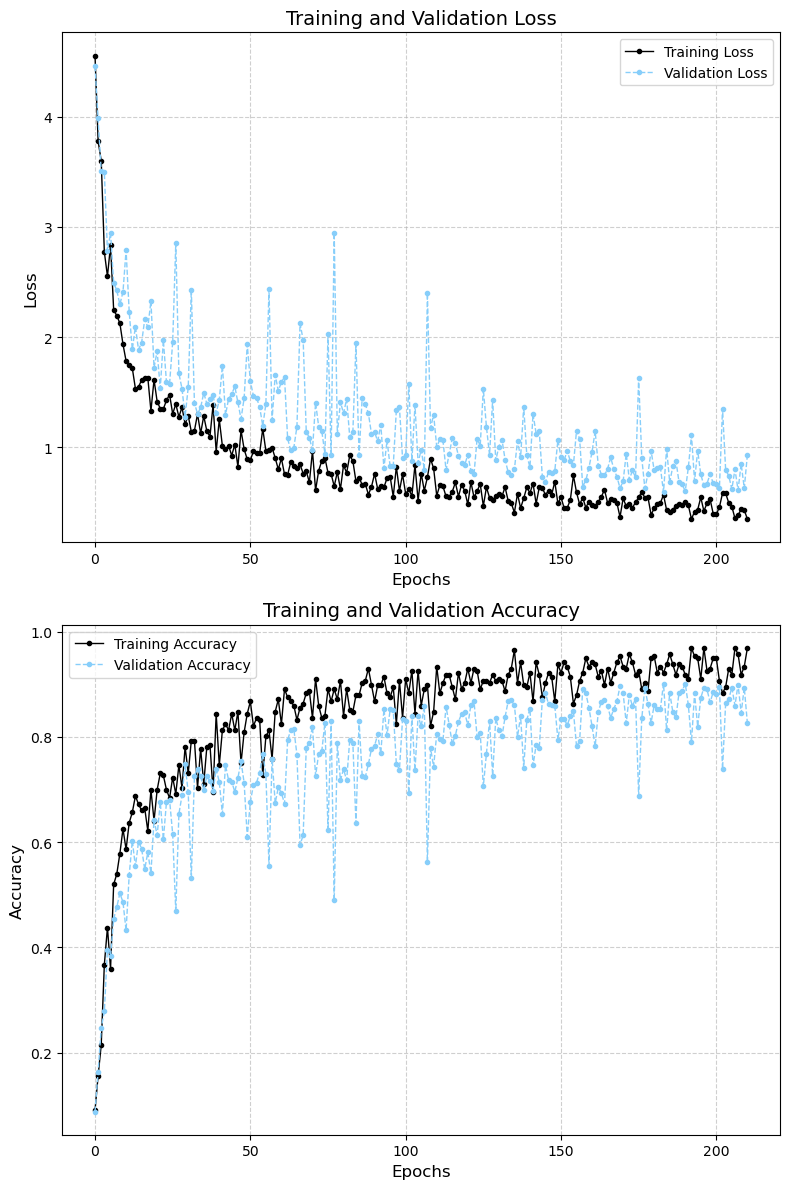

In [25]:
# Encoder
## Training graph
dir_results_encoder_simclr = '/home/dvillacreses/code/outputs/simclr_logs/train_simclr_resnet/version_9/metrics.csv'
df_encoder_simclr = pd.read_csv(dir_results_encoder_simclr)

cond_x = lambda x: ~x['train_acc_top1'].isna()
df_encoder_simclr.loc[cond_x, 'max_step'] = df_encoder_simclr[cond_x].groupby('epoch')['step'].transform("max")
cond_1 = lambda x: x['max_step'] == x['step']
cond_2 = lambda x: ~x['val_acc_top1'].isna()

df_encoder_simclr = pd.merge(
    left=df_encoder_simclr.loc[cond_1,['epoch','train_acc_top1','train_loss']],
    right=df_encoder_simclr.loc[cond_2,['epoch','val_acc_top1','val_loss']],
    on='epoch'
)

epochs = df_encoder_simclr['epoch']
train_loss = df_encoder_simclr['train_loss']
val_loss = df_encoder_simclr['val_loss']
train_acc = df_encoder_simclr['train_acc_top1']
val_acc = df_encoder_simclr['val_acc_top1']

## Graph
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

axes[0].plot(epochs, train_loss, label='Training Loss', marker='.', linestyle='-', linewidth=1, color = 'black')
axes[0].plot(epochs, val_loss, label='Validation Loss', marker='.', linestyle='--', linewidth=1, color = 'lightskyblue')
axes[0].set_title('Training and Validation Loss', fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(visible=True, linestyle='--', alpha=0.6)

axes[1].plot(epochs, train_acc, label='Training Accuracy', marker='.', linestyle='-', linewidth=1, color = 'black')
axes[1].plot(epochs, val_acc, label='Validation Accuracy', marker='.', linestyle='--', linewidth=1, color = 'lightskyblue')
axes[1].set_title('Training and Validation Accuracy', fontsize=14)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(visible=True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT_GRAPHS,'simclr_encoder_training.eps'), format="eps", dpi=600)
plt.show()


In [26]:
print(f"{df_encoder_simclr['train_acc_top1'].max()=}")
print(f"{df_encoder_simclr['val_acc_top1'].max()=}")

# df_encoder_simclr['train_acc_top1'].max()=0.96875
# df_encoder_simclr['val_acc_top1'].max()=0.901223599910736

df_encoder_simclr['train_acc_top1'].max()=0.96875
df_encoder_simclr['val_acc_top1'].max()=0.901223599910736


In [27]:
# Table to LaTex
df_grid_simclr_latex = df_grid_simclr.copy()
columns_to_format = ['lr'] 
decimal_places = 5
df_grid_simclr_latex[columns_to_format] = df_grid_simclr_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")

columns_to_format = ['weight_decay'] 
decimal_places = 3
df_grid_simclr_latex[columns_to_format] = df_grid_simclr_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")

df_grid_simclr_latex['valid_acc'] = np.round(df_grid_simclr_latex['valid_acc'] , 4)

columns_to_format = ['valid_acc'] 
decimal_places = 4
df_grid_simclr_latex[columns_to_format] = df_grid_simclr_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")

df_grid_simclr_latex.to_latex(os.path.join(PATH_OUTPUT_TABLES, 'simclr_classifier_grid_results.tex'), index=False)

/tmp/ipykernel_3390736/2454687729.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grid_simclr_latex[columns_to_format] = df_grid_simclr_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")
/tmp/ipykernel_3390736/2454687729.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grid_simclr_latex[columns_to_format] = df_grid_simclr_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")
/tmp/ipykernel_3390736/2454687729.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grid_simclr_latex[columns_to_format] = df_grid_simclr_latex[columns_to_format].applymap(lambda x: f"{x:.{decimal_places}f}")


In [28]:
print(f"{df_grid_simclr['valid_acc'].max()=}")

df_grid_simclr['valid_acc'].max()=0.8404471278190613


### All models

0 EfficientNet
1 ResNet
2 VGG
3 ViT


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


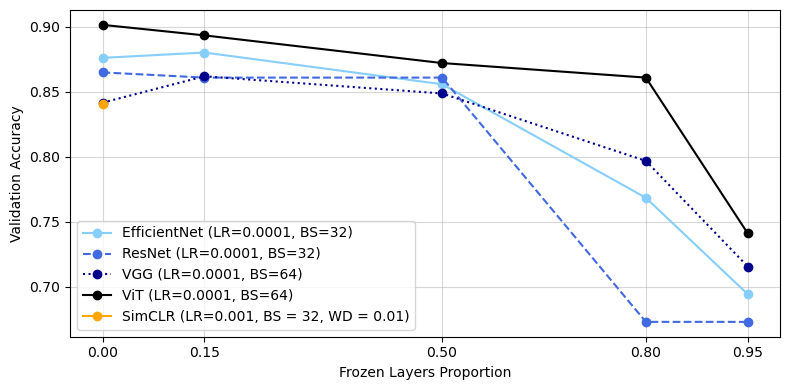

In [29]:
# Summary graph of supervised and SimCLR
df_grid['val_acc_max'] = df_grid.groupby('Model')['Validation Accuracy'].transform('max')
best_sl_models_index = df_grid[lambda x: x['Validation Accuracy'] == x['val_acc_max']].index

filter_dict = {}
for i, key in enumerate(['EfficientNet','ResNet','VGG','ViT']):
    filter_dict[key] = df_grid.iloc[best_sl_models_index[i],0:3].to_dict()
    print(i, key)


## Data
frozen_layers = df_grid['Frozen Layers Proportion'].unique()
efficientnet_acc = df_grid.loc[(df_grid[list(filter_dict['EfficientNet'].keys())] == pd.Series(filter_dict['EfficientNet'])).all(axis=1),'Validation Accuracy']
resnet_acc = df_grid.loc[(df_grid[list(filter_dict['ResNet'].keys())] == pd.Series(filter_dict['ResNet'])).all(axis=1),'Validation Accuracy']
bgg_acc = df_grid.loc[(df_grid[list(filter_dict['VGG'].keys())] == pd.Series(filter_dict['VGG'])).all(axis=1),'Validation Accuracy']
vit_acc = df_grid.loc[(df_grid[list(filter_dict['ViT'].keys())] == pd.Series(filter_dict['ViT'])).all(axis=1),'Validation Accuracy']

## Plot
plt.figure(figsize=(8, 4))

plt.plot(frozen_layers, 
         efficientnet_acc, 
         label=f"{filter_dict['EfficientNet']['Model']} (LR={filter_dict['EfficientNet']['Learning Rate']}, BS={filter_dict['EfficientNet']['Batch Size']})", 
         marker='o', 
         color='lightskyblue')
plt.plot(frozen_layers, 
         resnet_acc, 
         label=f"{filter_dict['ResNet']['Model']} (LR={filter_dict['ResNet']['Learning Rate']}, BS={filter_dict['ResNet']['Batch Size']})", 
         marker='o', 
         color='royalblue', 
         linestyle='--')
plt.plot(frozen_layers, 
         bgg_acc, 
         label=f"{filter_dict['VGG']['Model']} (LR={filter_dict['VGG']['Learning Rate']}, BS={filter_dict['VGG']['Batch Size']})", 
         marker='o', 
         color='darkblue', 
         linestyle=':')
plt.plot(frozen_layers, 
         vit_acc, 
         label=f"{filter_dict['ViT']['Model']} (LR={filter_dict['ViT']['Learning Rate']}, BS={filter_dict['ViT']['Batch Size']})", 
         marker='o', 
         color='black')

plt.plot(frozen_layers, 
         [0.8404,None,None,None,None], 
         label=f"SimCLR (LR=0.001, BS = 32, WD = 0.01)", 
         marker='o', 
         color='orange')

plt.xlabel('Frozen Layers Proportion')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.5)
plt.xticks(frozen_layers)
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT_GRAPHS,'summary_best_models.eps'), format="eps", dpi=600)
plt.show()

### t-SNE for embeddings

In [30]:
# Get Embedding from SimCLR
train_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='train','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='train','label'].to_list(),
    transform=val_transform_labeled_simclr
    )
valid_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
    transform=val_transform_labeled_simclr
    )
test_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='test','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='test','label'].to_list(),
    transform=val_transform_labeled_simclr
    )

labeled_datamodule = LabeledDataModule(train_dataset_labeled, 
                                    valid_dataset_labeled, 
                                    test_dataset_labeled, 
                                    batch_size=32,
                                    num_workers=NUM_WORKERS_SUPERVISED)
valid_loader_classifier = labeled_datamodule.val_dataloader()

valid_feats_simclr = prepare_data_features(simclr_model, valid_loader_classifier)

## From Features for Classifier from SimCLR compute t-SNE
standard_scaler = StandardScaler()
tsne = TSNE(n_components=2, random_state=0, max_iter=10_000)
embeddings_tsne_simclr = tsne.fit_transform(standard_scaler.fit_transform(valid_feats_simclr.tensors[0]))

# Get Embeddings from best ViT
vit_model = ViTLightningModule.load_from_checkpoint(all_results_list[0][63][2])
vit_model = vit_model.to(torch.device("cpu"))
embedding_extractor = EmbeddingExtractor_VIT(vit_model, layer_idx=-1, use_cls_token=True)

valid_dataset_labeled = LabeledImageDataset(
    image_list = df_balanced.loc[df_balanced['subset']=='valid','cropped_image'].to_list(),
    labels=df_balanced.loc[df_balanced['subset']=='valid','label'].to_list(),
    transform=val_transform_labeled_vit
    )
val_loader = LabeledDataModule(valid_dataset_labeled,
                               valid_dataset_labeled,
                               valid_dataset_labeled,
                               batch_size=984,
                               num_workers=os.cpu_count()).val_dataloader()
val_toch = next(iter(val_loader))[0].to('cpu')
embeddings_vit = embedding_extractor(val_toch)
embeddings_tsne_vit = tsne.fit_transform(standard_scaler.fit_transform(embeddings_vit.detach().numpy()))

  0%|          | 0/31 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


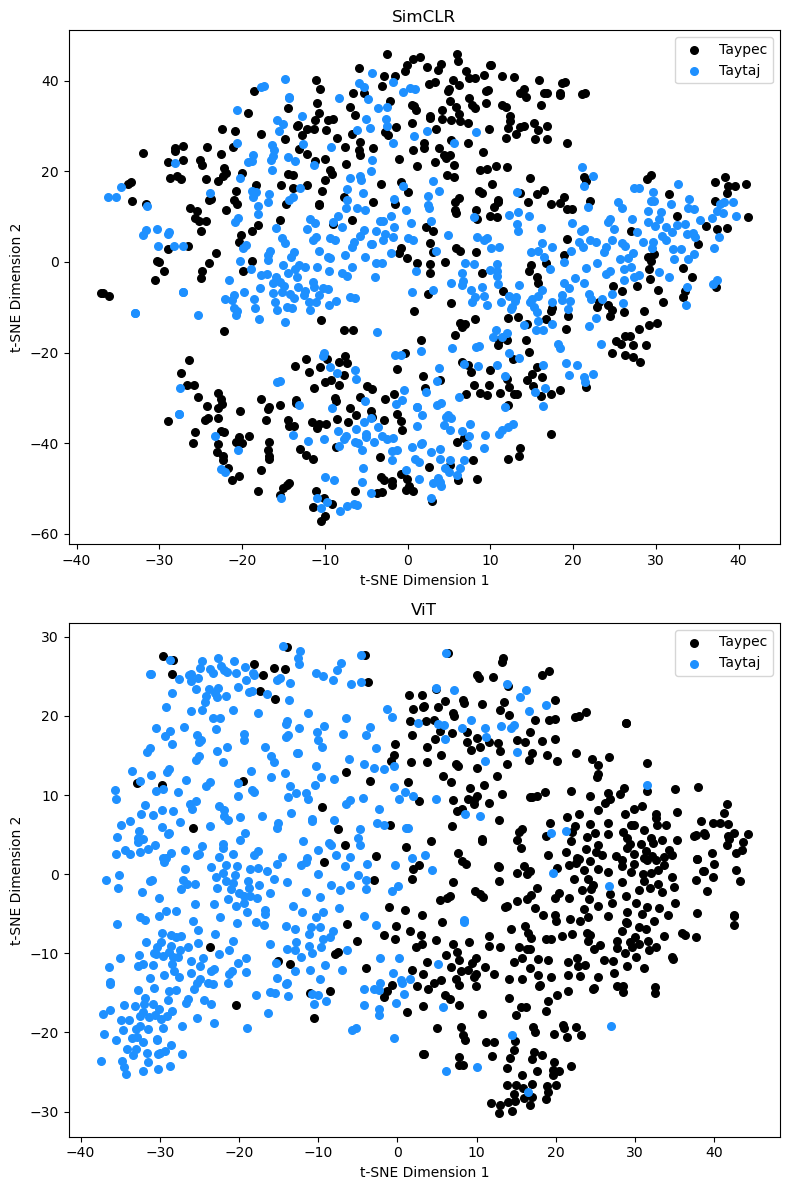

In [31]:
# Define colors and labels
colors = {0: "black", 1: "dodgerblue"}
labels = {0: "Taypec", 1: "Taytaj"}

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 12))  # 1 row, 2 columns

# Plot SimCLR data
for class_label in [0, 1]:
    axes[0].scatter(
        embeddings_tsne_simclr[valid_feats_simclr.tensors[1] == class_label, 0],
        embeddings_tsne_simclr[valid_feats_simclr.tensors[1] == class_label, 1],
        c=colors[class_label],
        label=labels[class_label],
        s=30
    )
axes[0].set_title("SimCLR")
axes[0].set_xlabel("t-SNE Dimension 1")
axes[0].set_ylabel("t-SNE Dimension 2")
axes[0].legend()

# Plot ViT data
for class_label in [0, 1]:
    axes[1].scatter(
        embeddings_tsne_vit[valid_feats_simclr.tensors[1] == class_label, 0],
        embeddings_tsne_vit[valid_feats_simclr.tensors[1] == class_label, 1],
        c=colors[class_label],
        label=labels[class_label],
        s=30
    )
axes[1].set_title("ViT")
axes[1].set_xlabel("t-SNE Dimension 1")
axes[1].set_ylabel("t-SNE Dimension 2")
axes[1].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT_GRAPHS,'embedding_best_models.eps'), format="eps", dpi=600)
plt.show()

### Individual images for specific areas of t-SNE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


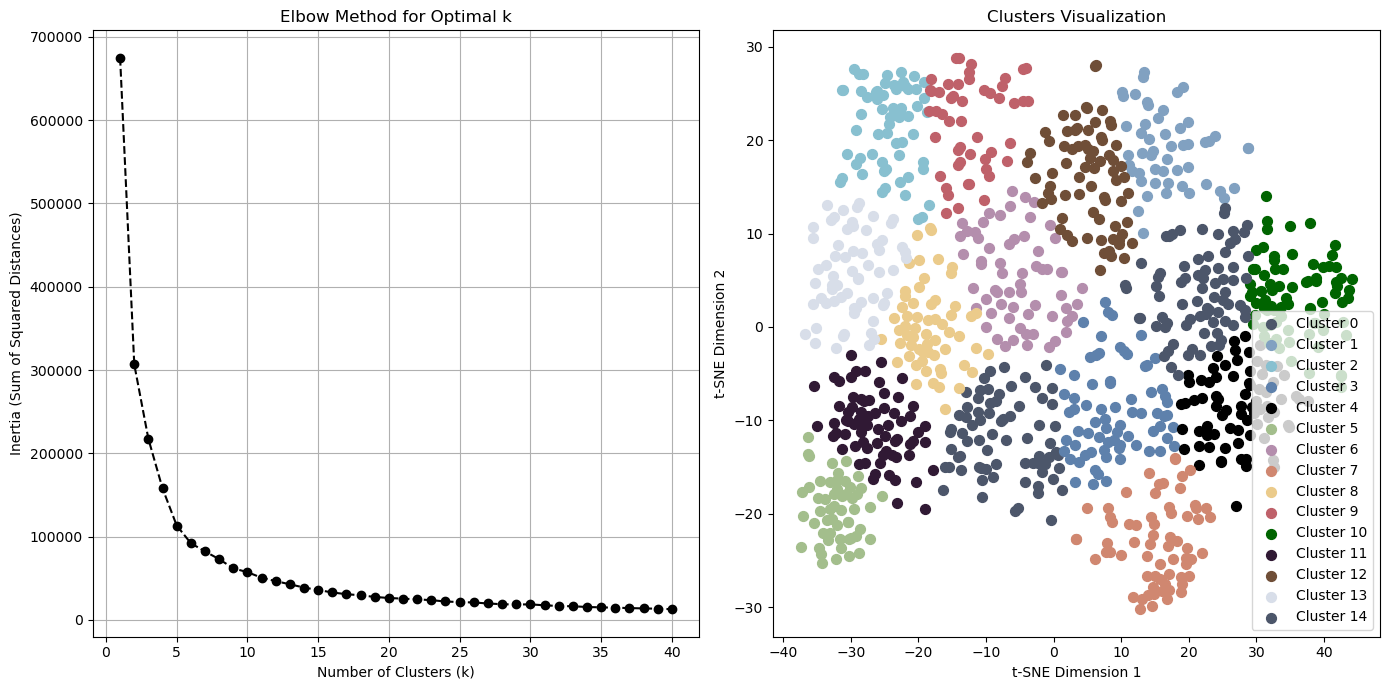

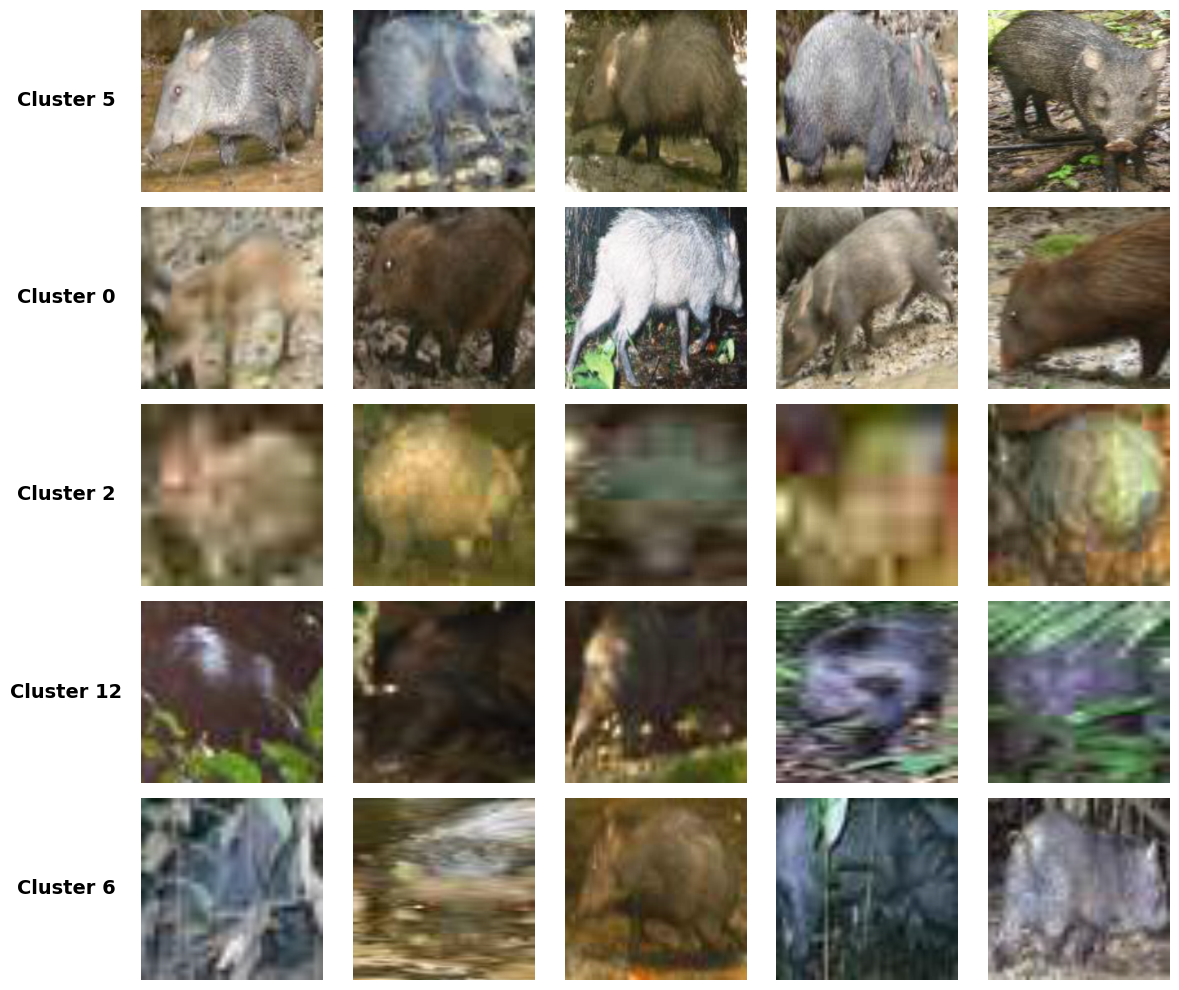

In [33]:
# k-means over best model embeddings
inertia = []
cluster_range = range(1, 41)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(np.hstack([embeddings_tsne_vit, np.array(valid_feats_simclr.tensors[1]).reshape(984,1)]))
    inertia.append(kmeans.inertia_)

## labels 
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(np.hstack([embeddings_tsne_vit, np.array(valid_feats_simclr.tensors[1]).reshape(984,1)]))

labels = kmeans.labels_ 

## Elbow Method graph and t-SNE with cluster colored
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
### Subplot 1: Elbow Method
axes[0].plot(cluster_range, inertia, marker='o', linestyle='--', color = 'black')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Sum of Squared Distances)')
axes[0].grid()

### Subplot 2: Scatter plot of clustered data
colors = [
    '#4C566A',  # Slate Gray
    '#81A1C1',  # Soft Blue
    '#88C0D0',  # Light Cyan
    '#5E81AC',  # Steel Blue
    '#000000',  # black
    '#A3BE8C',  # Sage Green
    '#B48EAD',  # Dusty Lavender
    '#D08770',  # Muted Orange
    '#EBCB8B',  # Sand Yellow
    '#BF616A',  # Soft Red
    '#006400',  # Dark Green
    '#301934',  # Dark Purple
    '#6F4E37',  # Coffee Brown
    '#D8DEE9'   # Light Gray-Blue
]
scatter_colors = [colors[i % len(colors)] for i in range(n_clusters)]
for class_label in range(n_clusters):
    cluster_data = embeddings_tsne_vit[labels == class_label]
    axes[1].scatter(
        cluster_data[:, 0],
        cluster_data[:, 1],
        label=f'Cluster {class_label}',
        color=scatter_colors[class_label],
        s=50
    )
axes[1].set_title('Clusters Visualization')
axes[1].set_xlabel("t-SNE Dimension 1")
axes[1].set_ylabel("t-SNE Dimension 2")
axes[1].legend()
plt.tight_layout()
plt.savefig(os.path.join(PATH_OUTPUT_GRAPHS,'cluster_graphs.eps'), format="eps", dpi=600)
plt.show()

## Individual Images per selected cluster
clusters_to_display = [5, 0, 2, 12, 6]
images_per_cluster = 5
random.seed(1)
fig = plt.figure(figsize=(12, 10))
#fig.suptitle('Sample Images from Selected Clusters', fontsize=20, weight='bold')
gs = GridSpec(len(clusters_to_display), images_per_cluster + 1, width_ratios=[0.5] + [1] * images_per_cluster)
for i, cluster in enumerate(clusters_to_display):
    ax_label = fig.add_subplot(gs[i, 0])
    ax_label.text(
        0.5, 0.5, f'Cluster {cluster}',
        fontsize=14, weight='bold', rotation=0,
        ha='center', va='center'
    )
    ax_label.axis('off')  # Hide axes for the label
    # Get indices of images belonging to the current cluster
    cluster_indices = list(np.where(labels == cluster)[0])
    selected_indices = random.sample(cluster_indices, images_per_cluster)
    for j, idx in enumerate(selected_indices):
        # Add image plots
        ax = fig.add_subplot(gs[i, j + 1])
        image = val_toch[idx].permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
        # Normalize image to [0, 1] range for visualization
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image)
        ax.axis('off')
plt.tight_layout() # Avoid innecesary spaces in graph
#plt.savefig(os.path.join(PATH_OUTPUT_GRAPHS,'selected_images_cluster_graph.eps'), format="eps", dpi=600)
plt.savefig(os.path.join(PATH_OUTPUT_GRAPHS,'selected_images_cluster_graph.png'), dpi=600)
plt.show()